<center>
    <h3><u>Application of Self-Organizing Maps to Satellite and Geophysical Datasets for Lithological Classification in Python.</u></h3>
</center>

This notebook uses Python geopandas, rasterio, numpy, pandas, matplotlib, scikit-learn and MiniSom to perform a SOM geospatial workflow. Each step is commented for clarity. 

The dataset used are <span style="color:red;">Sentinel-2</span>, <span style="color:red;">airborne geophysical data</span> and a <span style="color:red;">shapefile</span> of the study area - <span style="color:red;">Malmbjerg</span>, <span style="color:red;">Greenland</span>.

The workflow is as follows:
1. Load and mask Sentinel-2 data
2. Load and preprocess airborne geophysical data
3. Load shapefile of study area
4. Perform SOM analysis
5. Evaluate model performance
6. Visualize results

This python version of the code aims to experiment the used Python code in terms of clarity, performance and ease of use.

The original R code was prepared by: Prof. Thorkild Rasmussen and Dr. Sara Kasmaeeyazdi, I hereby thank and recognize their work. I rewrote this code for my own learning and research purposes.    

In [85]:
# Installing required packages

# !pip install geopandas rasterio pandas numpy matplotlib scikit-learn minisom seaborn

#import sys

#!{sys.executable} -m pip install minisom
#!{sys.executable} -m pip install geopandas

In [86]:
# Imports and basic configuration
# Ignore warnings

import os
import sys
import warnings
warnings.filterwarnings('ignore')


# Importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from minisom import MiniSom


# Geospatial libraries

import geopandas as gpd


In [87]:
# Loading Data
csv_path = "FEG-Y_Data.csv"

# Read CSV into pandas DataFrame
df = pd.read_csv(csv_path)
print('Dataframe loaded. Rows, columns:', df.shape)
print('Columns:', list(df.columns))

Dataframe loaded. Rows, columns: (273306, 20)
Columns: ['id', 'lon', 'lat', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'b8a', 'b9', 'b11', 'b12', 'sep_pg_100m', 'log_aRES140kHz', 'log_aRES40kHz', 'X', 'Y']


In [88]:
# Quick description of the data
display(df.head(20))
display(df.describe(include='all').T)
display("dtypes", df.dtypes)


,id,lon,lat,b1,b2,b3,b4,b5,b6,b7,b8,b8a,b9,b11,b12,sep_pg_100m,log_aRES140kHz,log_aRES40kHz,X,Y
0,s1,-24.311609,71.976659,0.1226,0.1157,0.1396,0.1509,0.1824,0.1722,0.1728,0.1570,0.1742,0.1549,0.1772,0.1592,0.00116,3.46,3.68,592812.41,7988400.11
1,s2,-24.311517,71.976659,0.1226,0.1157,0.1396,0.1509,0.1824,0.1722,0.1728,0.1570,0.1742,0.1549,0.1772,0.1592,0.00117,3.46,3.67,592815.58,7988400.26
2,s3,-24.311425,71.976659,0.1226,0.1157,0.1396,0.1509,0.1458,0.1401,0.1491,0.1570,0.1462,0.1549,0.1892,0.1746,0.00117,3.45,3.67,592818.76,7988400.40
3,s4,-24.311333,71.976659,0.1226,0.1098,0.1305,0.1439,0.1458,0.1401,0.1491,0.1482,0.1462,0.1549,0.1892,0.1746,0.00118,3.44,3.67,592821.93,7988400.54
4,s5,-24.311241,71.976659,0.1226,0.1098,0.1305,0.1439,0.1458,0.1401,0.1491,0.1482,0.1462,0.1549,0.1892,0.1746,0.00119,3.44,3.66,592825.10,7988400.68
5,s6,-24.311149,71.976659,0.1226,0.1098,0.1305,0.1439,0.1458,0.1401,0.1491,0.1482,0.1462,0.1549,0.1892,0.1746,0.00119,3.43,3.66,592828.27,7988400.82
6,s7,-24.311057,71.976659,0.1226,0.1025,0.1281,0.1354,0.1458,0.1401,0.1491,0.1390,0.1462,0.1549,0.1892,0.1746,0.00120,3.43,3.66,592831.44,7988400.96
7,s8,-24.310965,71.976659,0.1226,0.1025,0.1281,0.1354,0.1458,0.1401,0.1491,0.1390,0.1462,0.1549,0.1892,0.1746,0.00121,3.42,3.65,592834.61,7988401.11
8,s9,-24.310873,71.976659,0.1226,0.1025,0.1281,0.1354,0.1458,0.1401,0.1491,0.1390,0.1462,0.1549,0.1892,0.1746,0.00122,3.42,3.65,592837.78,7988401.25
9,s10,-24.310782,71.976659,0.1226,0.1027,0.1304,0.1394,0.1458,0.1401,0.1491,0.1382,0.1462,0.1549,0.1892,0.1746,0.00122,3.42,3.65,592840.95,7988401.39


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,273306,273306,s1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lon,273306.0,NaN,NaN,NaN,-24.271771,0.023019,-24.311609,-24.291665,-24.271814,-24.251871,-24.231928
lat,273306.0,NaN,NaN,NaN,71.962237,0.008354,71.947802,71.95497,71.962231,71.969491,71.976659
b1,273306.0,NaN,NaN,NaN,0.182974,0.130397,0.0002,0.0759,0.1431,0.2578,0.7821
b2,273306.0,NaN,NaN,NaN,0.195528,0.151303,0.0001,0.0843,0.1342,0.2702,1.0625
b3,273306.0,NaN,NaN,NaN,0.219139,0.151755,0.0025,0.1136,0.1601,0.2876,1.124
b4,273306.0,NaN,NaN,NaN,0.220997,0.144257,0.016,0.132,0.175,0.2632,1.1585
b5,273306.0,NaN,NaN,NaN,0.227799,0.145527,0.0258,0.1403,0.1824,0.2628,1.0614
b6,273306.0,NaN,NaN,NaN,0.209798,0.130582,0.0252,0.1354,0.1715,0.2364,0.9741
b7,273306.0,NaN,NaN,NaN,0.191886,0.116263,0.0203,0.1275,0.1606,0.2083,0.8713


'dtypes'

id                 object
lon               float64
lat               float64
b1                float64
b2                float64
b3                float64
b4                float64
b5                float64
b6                float64
b7                float64
b8                float64
b8a               float64
b9                float64
b11               float64
b12               float64
sep_pg_100m       float64
log_aRES140kHz    float64
log_aRES40kHz     float64
X                 float64
Y                 float64
dtype: object

In [89]:
# Missing values
missing_values = df.isnull().sum()
display("missing_values", missing_values)

# Duplicates
duplicates = df.duplicated().sum()
display("duplicates", duplicates)

# Outliers
outliers = df.describe()
display("outliers", outliers)

'missing_values'

id                0
lon               0
lat               0
b1                0
b2                0
b3                0
b4                0
b5                0
b6                0
b7                0
b8                0
b8a               0
b9                0
b11               0
b12               0
sep_pg_100m       0
log_aRES140kHz    0
log_aRES40kHz     0
X                 0
Y                 0
dtype: int64

'duplicates'

0

'outliers'

,lon,lat,b1,b2,b3,b4,b5,b6,b7,b8,b8a,b9,b11,b12,sep_pg_100m,log_aRES140kHz,log_aRES40kHz,X,Y
count,273306.000000,273306.000000,273306.000000,273306.000000,273306.000000,273306.000000,273306.000000,273306.000000,273306.000000,273306.000000,273306.000000,273306.000000,273306.000000,273306.000000,273306.000000,273306.000000,273306.000000,273306.000000,2.733060e+05
mean,-24.271771,71.962237,0.182974,0.195528,0.219139,0.220997,0.227799,0.209798,0.191886,0.180094,0.172921,0.164242,0.123217,0.106984,0.002824,3.836785,3.825418,594259.740516,7.986855e+06
std,0.023019,0.008354,0.130397,0.151303,0.151755,0.144257,0.145527,0.130582,0.116263,0.112546,0.105949,0.100232,0.110274,0.094393,0.000996,0.571778,0.482557,795.941360,9.316268e+02
min,-24.311609,71.947802,0.000200,0.000100,0.002500,0.016000,0.025800,0.025200,0.020300,0.016500,0.020200,0.032600,0.006500,0.005400,0.001010,-0.600000,1.790000,592812.410000,7.985186e+06
25%,-24.291665,71.954970,0.075900,0.084300,0.113600,0.132000,0.140300,0.135400,0.127500,0.117400,0.112200,0.098800,0.018300,0.016300,0.002010,3.400000,3.470000,593571.425000,7.986049e+06
50%,-24.271814,71.962231,0.143100,0.134200,0.160100,0.175000,0.182400,0.171500,0.160600,0.152000,0.146700,0.146300,0.092300,0.081700,0.002690,3.700000,3.800000,594259.760000,7.986855e+06
75%,-24.251871,71.969491,0.257800,0.270200,0.287600,0.263200,0.262800,0.236400,0.208300,0.191800,0.183200,0.186500,0.211100,0.185300,0.003470,4.450000,4.270000,594948.060000,7.987661e+06
max,-24.231928,71.976659,0.782100,1.062500,1.124000,1.158500,1.061400,0.974100,0.871300,0.998500,0.780800,0.674800,0.605200,0.522400,0.006480,4.780000,4.550000,595707.990000,7.988525e+06


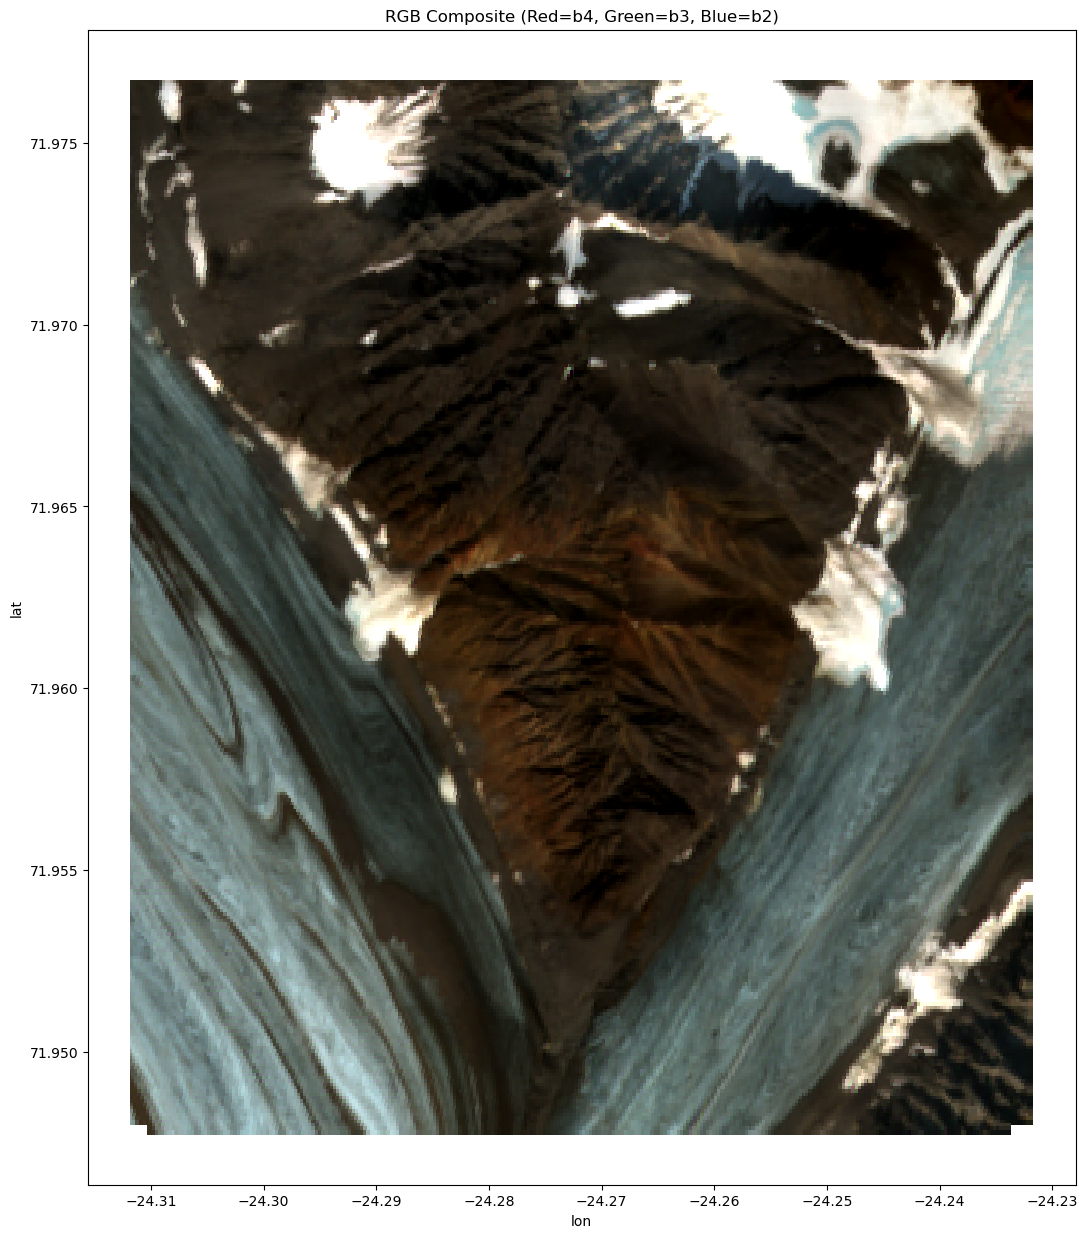

In [90]:
# Data visualization    

def visualize_rgb(csv_path):
    
    # Extracting bands...
    red = df['b4']
    green = df['b3']
    blue = df['b2']
    
    # Stack into an (N, 3) array for scatter plot colors
    rgb_points = np.column_stack((red, green, blue))
    
    # Normalize the data for visualization
    # Clip to the 2nd and 98th percentiles to enhance contrast
    p2, p98 = np.percentile(rgb_points, (2, 98))
    
    # Avoid division by zero
    if p98 - p2 == 0:
        rgb_points_norm = rgb_points
    else:
        rgb_points_norm = np.clip((rgb_points - p2) / (p98 - p2), 0, 1)
    
    #Plotting...
    plt.figure(figsize=(15, 15))
    x_col, y_col = 'lon', 'lat'
    mean_lat = df['lat'].mean()

    if mean_lat is not None:
        plt.gca().set_aspect(1.0 / np.cos(np.radians(mean_lat)))

    
    # Use 'lon' and 'lat' columns
    if 'lon' in df.columns and 'lat' in df.columns:
        x_col, y_col = 'lon', 'lat'
        
    plt.scatter(df[x_col], df[y_col], c=rgb_points_norm, s=15, marker='s', edgecolors='none', alpha=1)
    plt.title('RGB Composite (Red=b4, Green=b3, Blue=b2)')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    #plt.axis('equal')
    plt.show()

visualize_rgb("FEG-Y_Data.csv")

## Masking


##### Masking = means removing the influence of cloud and shadow pixels from the satellite image. To do this we use the Normalized Difference Snow Index (NDSI). And, we need to look the histogram of the bands to define the thresholds.

###### Masking: NDSI= (B3-B11)/(B3+B11) 

In [91]:
# Calculating NDSI

df['NDSI'] = (df['b3'] - df['b11']) / (df['b3'] + df['b11'])

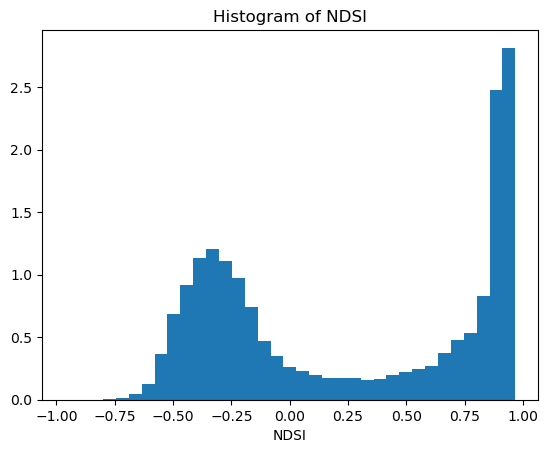

In [92]:
# Histogram of NDSI

plt.hist(df['NDSI'], bins=35, density=True)
plt.title('Histogram of NDSI')
plt.xlabel('NDSI')
plt.show()

##### Masking snow with 0.4 threshold (Hofmeister, 2022) 

* Removing bands values that represent snow (above threshold)

In [93]:
def masking_snow(series, threshold):
    return np.where(series < threshold, series, np.nan)

df['Masked_snow'] = masking_snow(df['NDSI'], 0.4)
df.head()

,id,lon,lat,b1,b2,b3,b4,b5,b6,b7,...,b9,b11,b12,sep_pg_100m,log_aRES140kHz,log_aRES40kHz,X,Y,NDSI,Masked_snow
0,s1,-24.311609,71.976659,0.1226,0.1157,0.1396,0.1509,0.1824,0.1722,0.1728,...,0.1549,0.1772,0.1592,0.00116,3.46,3.68,592812.41,7988400.11,-0.118687,-0.118687
1,s2,-24.311517,71.976659,0.1226,0.1157,0.1396,0.1509,0.1824,0.1722,0.1728,...,0.1549,0.1772,0.1592,0.00117,3.46,3.67,592815.58,7988400.26,-0.118687,-0.118687
2,s3,-24.311425,71.976659,0.1226,0.1157,0.1396,0.1509,0.1458,0.1401,0.1491,...,0.1549,0.1892,0.1746,0.00117,3.45,3.67,592818.76,7988400.40,-0.150852,-0.150852
3,s4,-24.311333,71.976659,0.1226,0.1098,0.1305,0.1439,0.1458,0.1401,0.1491,...,0.1549,0.1892,0.1746,0.00118,3.44,3.67,592821.93,7988400.54,-0.183610,-0.183610
4,s5,-24.311241,71.976659,0.1226,0.1098,0.1305,0.1439,0.1458,0.1401,0.1491,...,0.1549,0.1892,0.1746,0.00119,3.44,3.66,592825.10,7988400.68,-0.183610,-0.183610


In [94]:
# Droping NaN values
df_omit = df.dropna(subset=['Masked_snow'])
df_omit.describe()


,lon,lat,b1,b2,b3,b4,b5,b6,b7,b8,...,b9,b11,b12,sep_pg_100m,log_aRES140kHz,log_aRES40kHz,X,Y,NDSI,Masked_snow
count,145289.000000,145289.000000,145289.000000,145289.000000,145289.000000,145289.000000,145289.000000,145289.000000,145289.000000,145289.000000,...,145289.000000,145289.000000,145289.000000,145289.000000,145289.000000,145289.000000,145289.000000,1.452890e+05,145289.000000,145289.000000
mean,-24.271823,71.964699,0.096626,0.093502,0.120852,0.141586,0.154248,0.152453,0.152405,0.146931,...,0.156899,0.208529,0.180801,0.002947,3.542988,3.642428,594245.581770,7.987129e+06,-0.245194,-0.245194
std,0.018950,0.007765,0.055742,0.041915,0.046044,0.051897,0.057622,0.056237,0.054123,0.052359,...,0.050858,0.082992,0.069110,0.000950,0.405576,0.421607,665.538326,8.581034e+02,0.222227,0.222227
min,-24.311609,71.947802,0.000200,0.000100,0.002500,0.016000,0.025800,0.025200,0.020300,0.016500,...,0.032600,0.013800,0.012800,0.001030,-0.600000,1.790000,592812.410000,7.985186e+06,-0.965730,-0.965730
25%,-24.284589,71.959014,0.060300,0.067700,0.092800,0.109400,0.118600,0.117200,0.117700,0.113000,...,0.125900,0.151700,0.135000,0.002240,3.310000,3.380000,593804.780000,7.986496e+06,-0.400729,-0.400729
50%,-24.272549,71.966182,0.079900,0.086900,0.117000,0.138500,0.148900,0.148300,0.149600,0.146800,...,0.149700,0.205200,0.180700,0.002790,3.510000,3.620000,594233.920000,7.987298e+06,-0.286702,-0.286702
75%,-24.258856,71.971053,0.114300,0.112100,0.142100,0.167500,0.180500,0.179100,0.179500,0.175800,...,0.179800,0.259000,0.225000,0.003590,3.740000,3.940000,594697.020000,7.987838e+06,-0.146333,-0.146333
max,-24.231928,71.976659,0.606600,0.697300,0.749200,0.823300,0.930000,0.892200,0.788300,0.774800,...,0.605400,0.605200,0.522400,0.006480,4.750000,4.530000,595707.990000,7.988525e+06,0.400000,0.400000


##### Visualization of the masking result
* To see if it removed the snow influenced areas

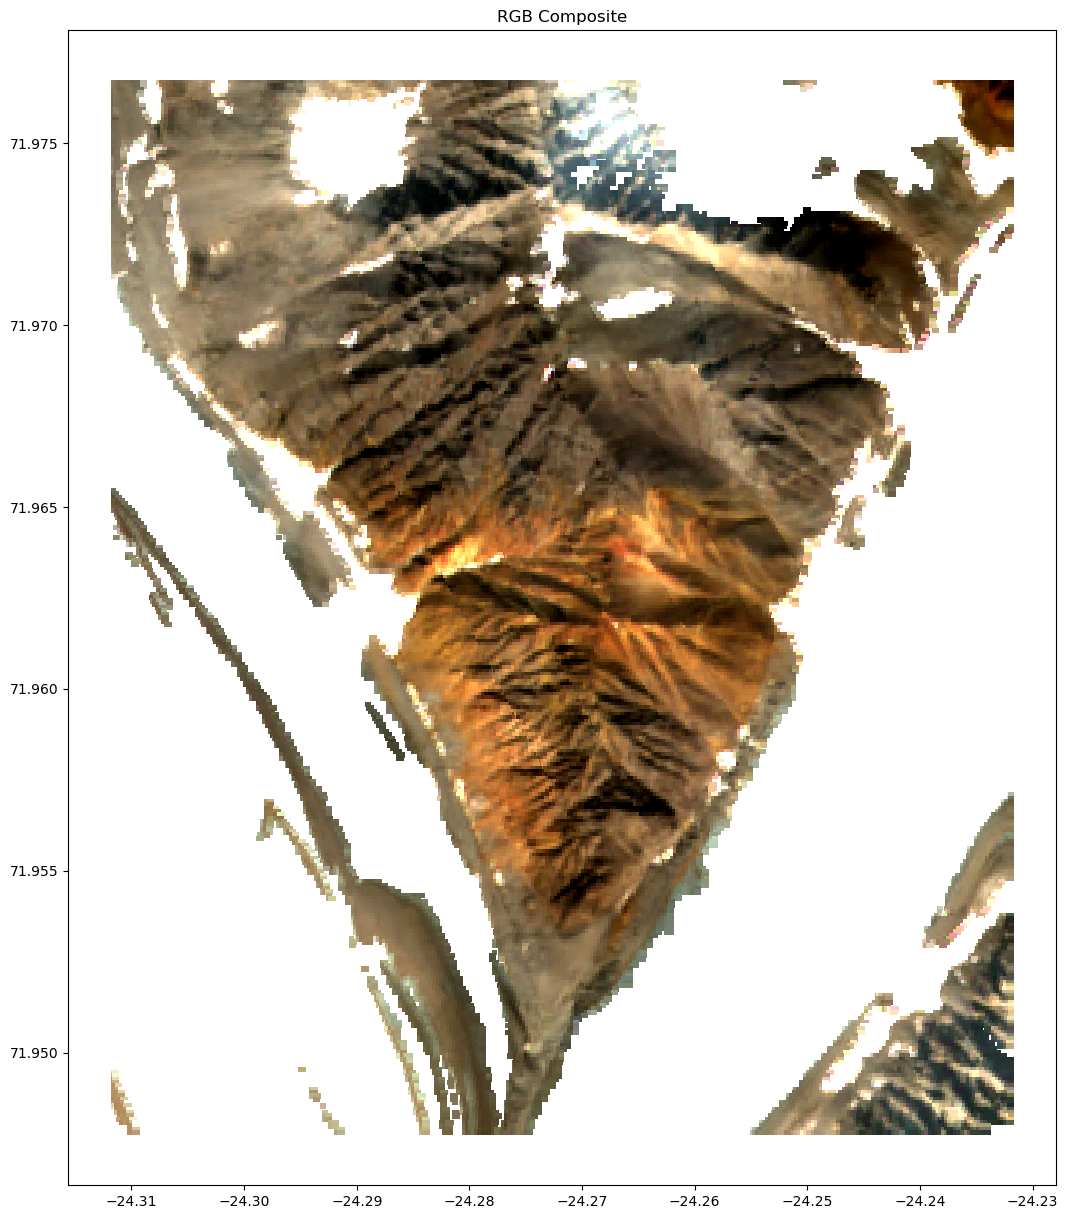

In [95]:
data = df_omit

# Stack bands (Red=b4, Green=b3, Blue=b2)
rgb = np.column_stack((data['b4'], data['b3'], data['b2']))

# Normalize
p2, p98 = np.nanpercentile(rgb, (2, 98))
rgb_norm = np.clip((rgb - p2) / (p98 - p2), 0, 1)

# Plot
plt.figure(figsize=(15, 15))
plt.scatter(data['lon'], data['lat'], c=rgb_norm, s=15, marker='s', edgecolors='none')
plt.gca().set_aspect(1.0 / np.cos(np.radians(data['lat'].mean())))
plt.title('RGB Composite')
plt.show()

In [96]:
df_omit = df

##### Self-Organization Map (SOM)

* SOM training

* ###### 1. Data Preparation: Selects bands and geophysical data (columns b1 to log_aRES40kHz).

* ###### 2. Data Normalization: Uses StandardScaler to zero mean and unit variance.

* ###### 3. SOM Training: Initializes a 20x20 grid with a Gaussian neighborhood function and random seed 200.

In [97]:
# 1. Data Preparation
# Selecting columns: bands b1-b12 + geophysical data

feature_cols = ['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'b8a', 'b9', 'b11', 'b12', 'sep_pg_100m', 'log_aRES140kHz', 'log_aRES40kHz']

# Ensure selected columns exist in the dataframe
selected_cols = [c for c in feature_cols if c in df.columns]
data_train = df[selected_cols]

In [98]:
# 2. Data Normalization
# Drop NA values to ensure clean training data
data_train_clean = data_train.dropna().reset_index(drop=True)

# Initialize StandardScaler
scaler = StandardScaler()
data_train_matrix = scaler.fit_transform(data_train_clean.values)
print('Normalized training matrix shape:', data_train_matrix.shape)



Normalized training matrix shape: (273306, 15)


In [99]:
# 3. SOM Model
# Grid 20x20, Rectangular topology, Gaussian neighborhood, Seed 200
x_dim, y_dim = 20, 20
input_len = data_train_matrix.shape[1]

print("Initializing SOM with rectangular topology...")
som = MiniSom(x_dim, y_dim, input_len, sigma=1.0, learning_rate=0.5, 
              neighborhood_function='gaussian', random_seed=200, topology='rectangular')

som.random_weights_init(data_train_matrix)

print('Training SOM... this may take a moment.')
som.train_random(data_train_matrix, 100)  # 100 iterations
print('SOM training completed.')

Initializing SOM with rectangular topology...
Training SOM... this may take a moment.
SOM training completed.


#### Training progress and plots

* U-Matrix (Neighbor Distance)

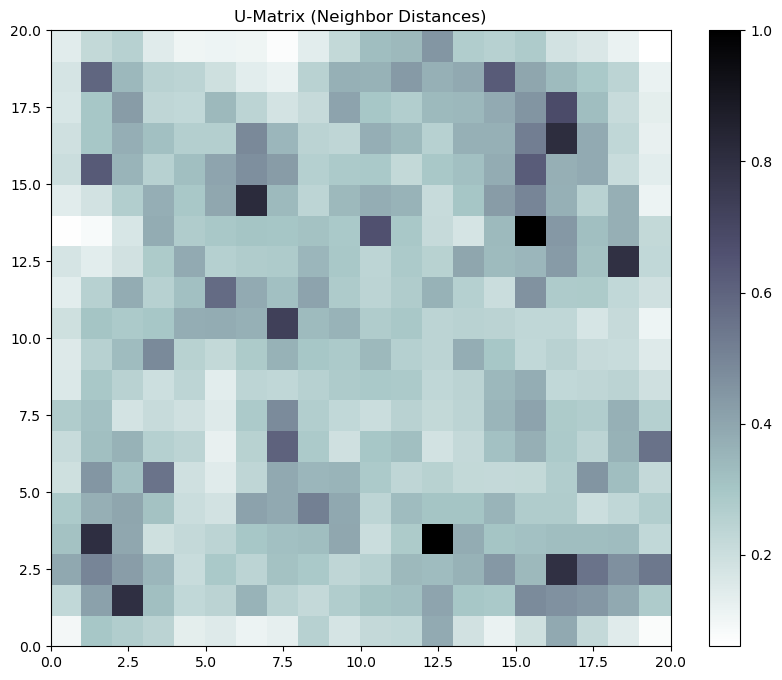

In [100]:
#1. U-Matrix (Neighbor Distance)
plt.figure(figsize=(10, 8))
plt.title('U-Matrix (Neighbor Distances)')

# distance_map() returns the U-matrix
u_matrix = som.distance_map()
plt.pcolor(u_matrix.T, cmap='bone_r') 
plt.colorbar()
plt.show()

* Counts Plot (Activation Response)

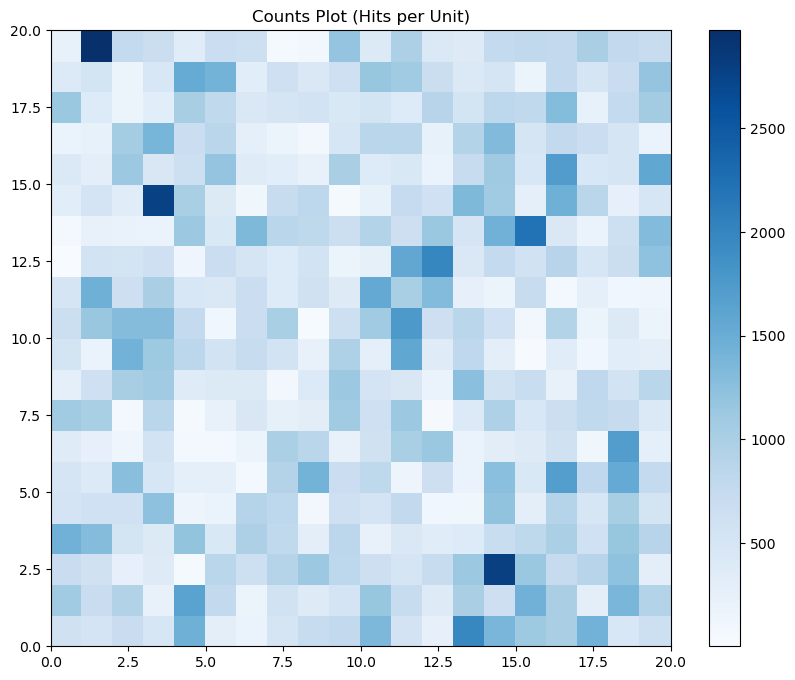

In [101]:
# 2. Counts Plot (Activation Response)
plt.figure(figsize=(10, 8))
plt.title('Counts Plot (Hits per Unit)')
frequencies = som.activation_response(data_train_matrix)
plt.pcolor(frequencies.T, cmap='Blues') 
plt.colorbar()
plt.show()

* Weight Vectors (Heatmaps per feature)

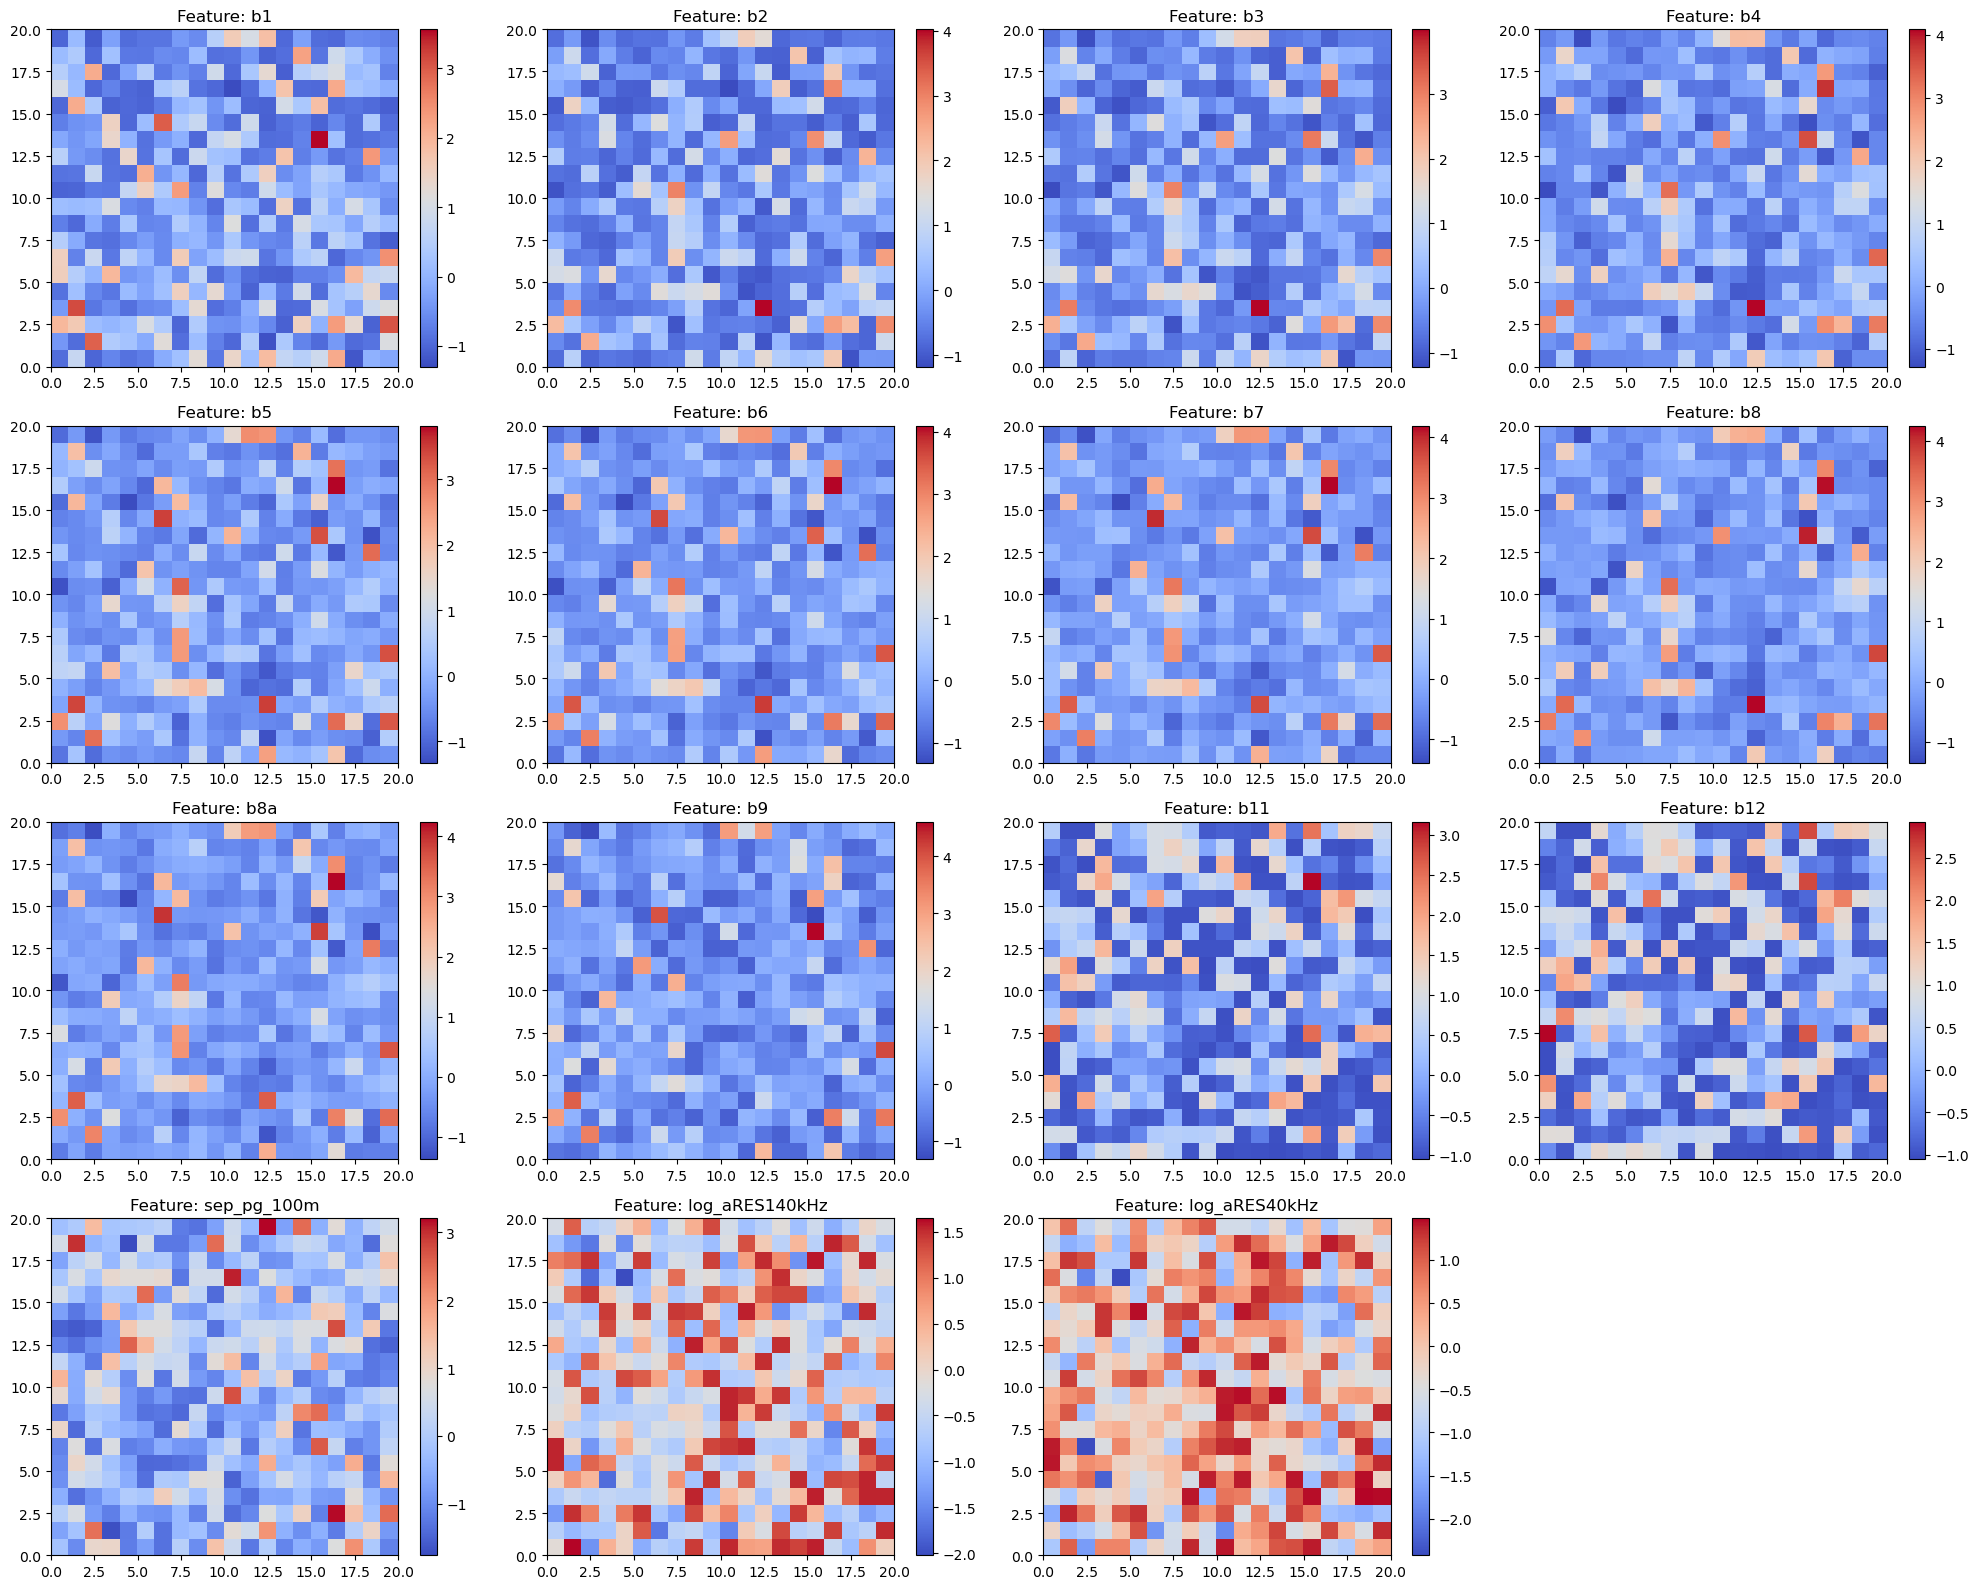

In [102]:
# 3. Weight Vectors (Heatmaps per feature)
weights = som.get_weights()
n_features = weights.shape[2]
feature_names = selected_cols # Using the columns we selected earlier

# Create a grid of subplots for features
n_cols = 4
n_rows = int(np.ceil(n_features / n_cols))

plt.figure(figsize=(20, 4 * n_rows))
for i in range(n_features):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.title(f'Feature: {feature_names[i]}')
    plt.pcolor(weights[:, :, i].T, cmap='coolwarm')
    plt.colorbar()
plt.tight_layout()
plt.show()


* Training Progress (Quantization Error)

Retraining a new model to visualize training progress...


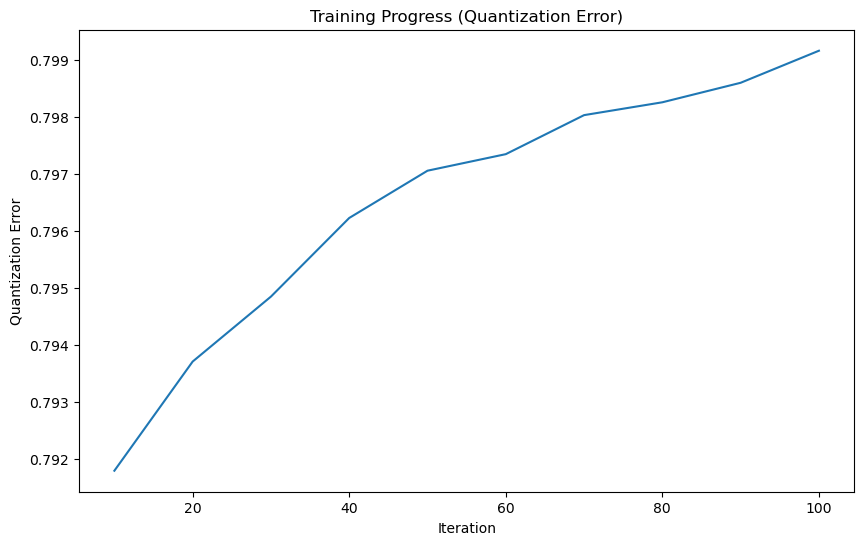

In [103]:
# 4. Training Progress (Quantization Error)
# Note: To see the curve, we need to track error during training. 
# Since the model is already trained, this block RETRAINS a new model to show the convergence.
print("Retraining a new model to visualize training progress...")
som_progress = MiniSom(x_dim, y_dim, input_len, sigma=1.0, learning_rate=0.5, 
              neighborhood_function='gaussian', random_seed=200, topology='rectangular')
som_progress.random_weights_init(data_train_matrix)

q_errors = []
iterations = 100
step = 10 # Check error every 10 iterations to save time

for i in range(0, iterations, step):
    som_progress.train_random(data_train_matrix, step)
    q_errors.append(som_progress.quantization_error(data_train_matrix))

plt.figure(figsize=(10, 6))
plt.plot(range(step, iterations + 1, step), q_errors)
plt.title('Training Progress (Quantization Error)')
plt.xlabel('Iteration')
plt.ylabel('Quantization Error')
plt.show()

* Bavies-Bouldin index

The Davies-Bouldin index is a metric used to determine the optimal number of clusters and measure the quality of clustering. This involves clustering the SOM weights using K-Means for a range of cluster counts (k) and calculating the index for each.

The smaller the Davies-Bouldin index, the better the clustering quality (Davies & Bouldin, 1979). It ranges from 0 to infinity, with lower values indicating better clustering. The optimal number of clusters is typically the one that minimizes the Davies-Bouldin index. 

Calculating Davies-Bouldin Index for k=2 to 20...


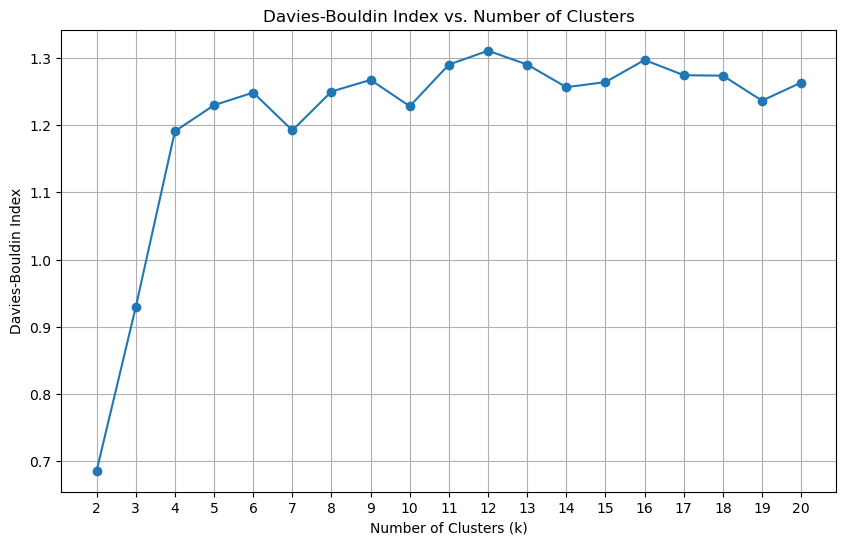

Optimal number of clusters according to Davies-Bouldin Index: 2


In [104]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

# Extract codebook (weight vectors) from the SOM
# Reshape to (n_units, n_features)
codebook = som.get_weights().reshape(-1, input_len)

# Calculate Davies-Bouldin Index for a range of clusters (k)
k_min, k_max = 2, 20
db_scores = []
k_values = range(k_min, k_max + 1)

print(f"Calculating Davies-Bouldin Index for k={k_min} to {k_max}...")

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=200, n_init=10)
    labels = kmeans.fit_predict(codebook)
    score = davies_bouldin_score(codebook, labels)
    db_scores.append(score)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, db_scores, marker='o')
plt.title('Davies-Bouldin Index vs. Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.grid(True)
plt.xticks(k_values)
plt.show()

# Find the optimal k (minimum DB index)
optimal_k = k_values[np.argmin(db_scores)]
print(f"Optimal number of clusters according to Davies-Bouldin Index: {optimal_k}")

## K-means clustering

Clustering SOM units into 9 clusters...


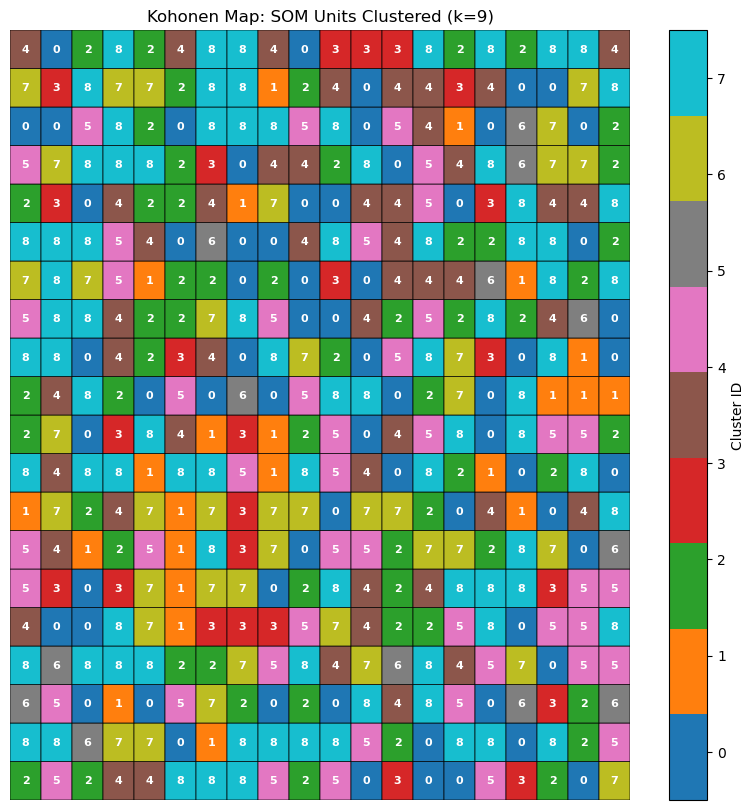

In [113]:
# Use optimal_k from previous step if available, otherwise default to 9
#if 'optimal_k' not in locals():
#    optimal_k = 9
#    print(f"optimal_k not found, using default k={optimal_k}")

optimal_k = 9

print(f"Clustering SOM units into {optimal_k} clusters...")

# Perform K-Means clustering on the codebook (weight vectors)
# codebook shape is (n_units, n_features)
kmeans = KMeans(n_clusters=optimal_k, random_state=200, n_init=10)
cluster_labels = kmeans.fit_predict(codebook)

# Reshape labels to match the SOM grid dimensions (20x20)
cluster_map = cluster_labels.reshape(x_dim, y_dim)

# Plotting the Kohonen Map with Clusters
plt.figure(figsize=(10, 10))
plt.title(f'Kohonen Map: SOM Units Clustered (k={optimal_k})')

# Use a discrete colormap
cmap = plt.cm.get_cmap('tab10', optimal_k) if optimal_k <= 10 else plt.cm.get_cmap('tab20', optimal_k)

# Plot the cluster map
# We transpose (.T) to align with the typical (x, y) grid visualization
plt.pcolor(cluster_map.T, cmap=cmap, edgecolors='k', linewidths=0.5)

# Add a colorbar
cbar = plt.colorbar(ticks=np.arange(optimal_k) + 0.5)
cbar.set_ticklabels(np.arange(optimal_k))
cbar.set_label('Cluster ID')

# Add text labels for cluster ID in each cell
for i in range(x_dim):
    for j in range(y_dim):
        # Calculate center of the cell
        plt.text(i + 0.5, j + 0.5, str(cluster_map[i, j]), 
                 horizontalalignment='center', verticalalignment='center',
                 fontsize=8, color='white', fontweight='bold')

plt.axis('off')
plt.show()

#### Cluster map

Mapping clusters back to the original data points...
Prepared dataframe with 273306 rows.


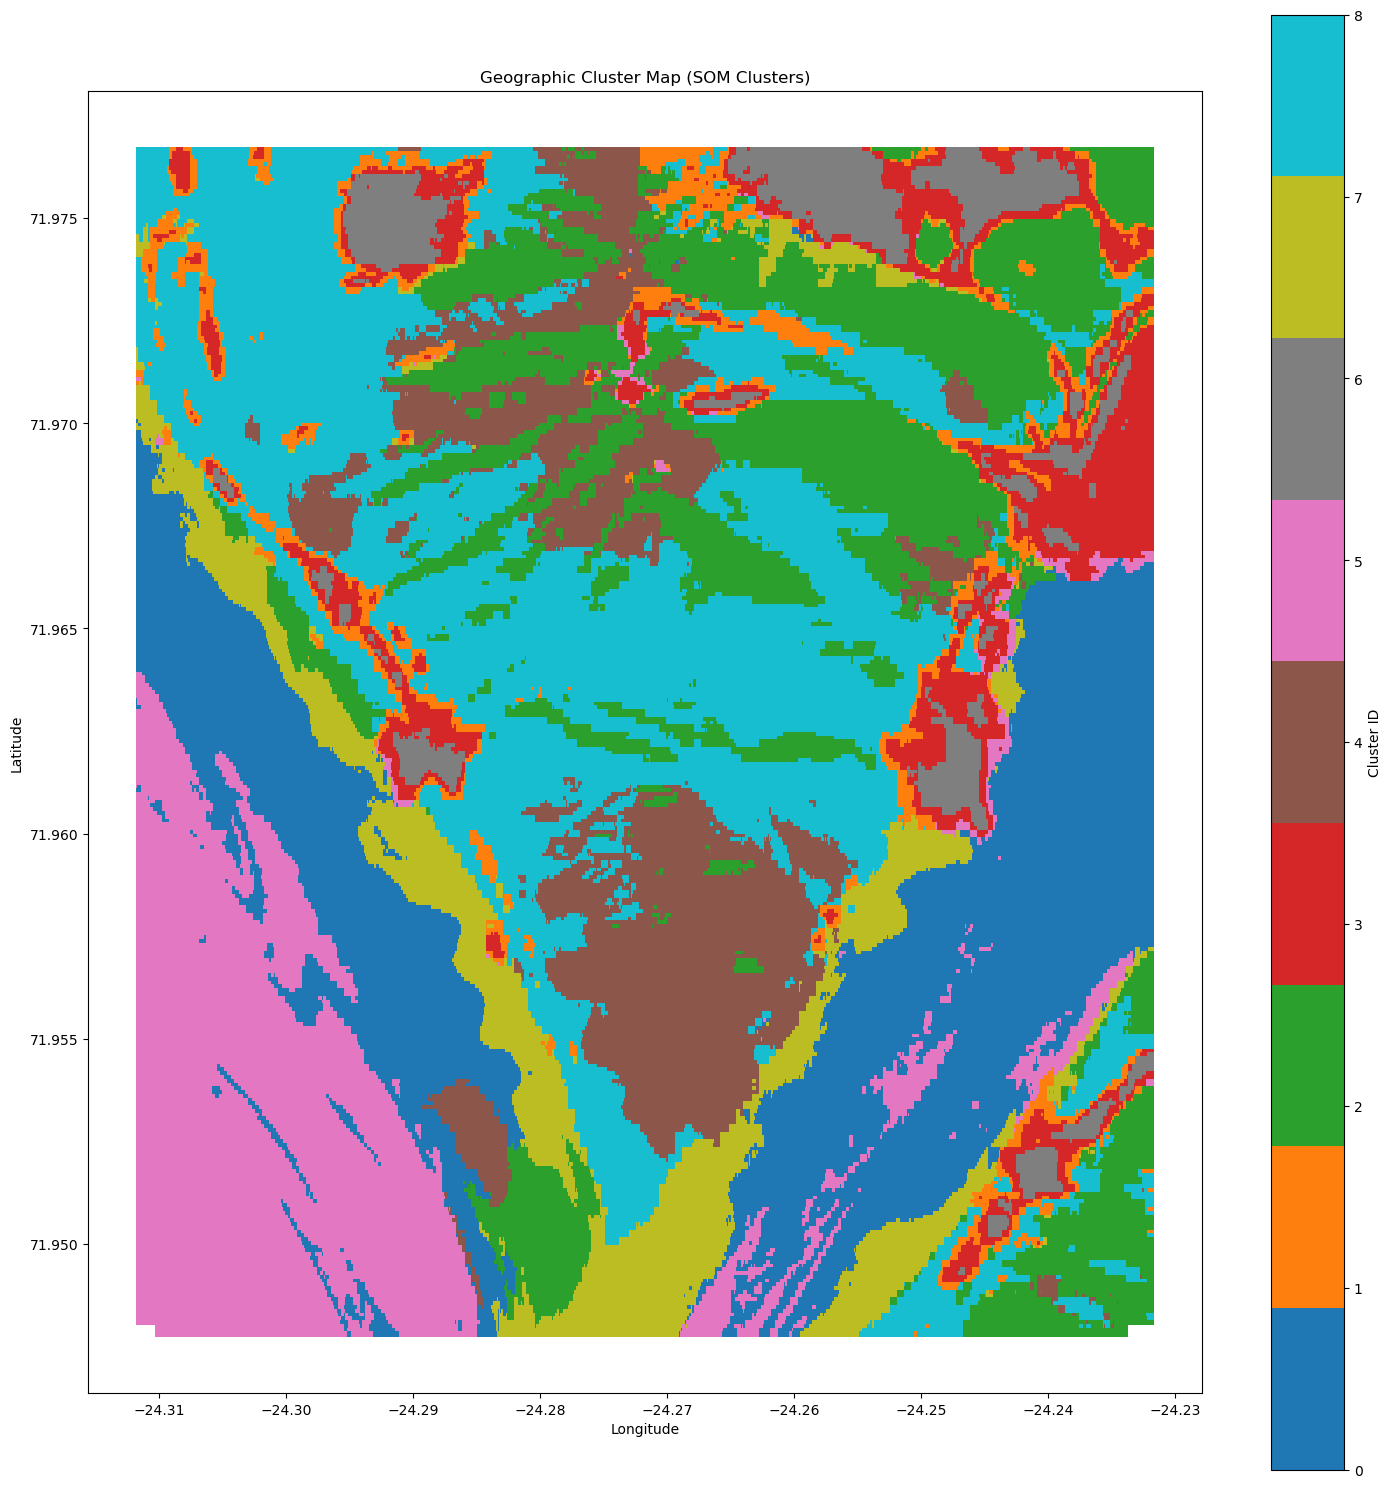

In [114]:
print("Mapping clusters back to the original data points...")

# 1. Create a dataframe that includes both features AND coordinates
# Start from the original df and select the features + coordinates
feature_cols = ['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'b8a', 'b9', 'b11', 'b12', 'sep_pg_100m', 'log_aRES140kHz', 'log_aRES40kHz']
selected_cols = [c for c in feature_cols if c in df.columns]

# Include coordinates in the selection
df_with_coords = df[selected_cols + ['lon', 'lat']].dropna(subset=selected_cols).reset_index(drop=True)

print(f"Prepared dataframe with {len(df_with_coords)} rows.")

# 2. Find the Best Matching Unit (BMU) for each data point
# We need to use the normalized features (same as training)
winners = [som.winner(x) for x in data_train_matrix]

# 3. Assign the cluster label of the BMU to the data point
sample_clusters = [cluster_map[win[0], win[1]] for win in winners]

# 4. Add the cluster labels to the dataframe
df_with_coords['cluster'] = sample_clusters

# 5. Plot the Geographic Cluster Map
plt.figure(figsize=(15, 15))

# Use a discrete colormap matching the number of clusters
n_clusters = len(np.unique(sample_clusters))
cmap = plt.cm.get_cmap('tab10', n_clusters) if n_clusters <= 10 else plt.cm.get_cmap('tab20', n_clusters)

plt.scatter(df_with_coords['lon'], df_with_coords['lat'], 
            c=df_with_coords['cluster'], 
            cmap=cmap, 
            s=15, 
            marker='s', 
            edgecolors='none', 
            alpha=1)

plt.title('Geographic Cluster Map (SOM Clusters)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Correct aspect ratio
mean_lat = df_with_coords['lat'].mean()
plt.gca().set_aspect(1.0 / np.cos(np.radians(mean_lat)))

# Add colorbar
cbar = plt.colorbar(ticks=np.arange(n_clusters))
cbar.set_label('Cluster ID')
cbar.set_ticklabels(np.arange(n_clusters))

plt.tight_layout()
plt.show()

In [112]:
# Save output with cluster labels - update the filename as desired
out_csv = "FEG-Y_Data_4_QGIS.csv"
df_with_clusters.to_csv(out_csv, index=False)
print('Saved merged dataframe with SOM clusters to', out_csv)

Saved merged dataframe with SOM clusters to FEG-Y_Data_4_QGIS.csv


# Geologic Interpretation of SOM-Derived Lithologic Domains at Malmbjerg

---

## Introduction

This report interprets the visual outputs from integrating **Sentinel-2 multispectral data**, **airborne resistivity measurements**, **Self-Organising Maps (SOM)**, and **K-means clustering** for lithological classification in the Malmbjerg area, East Greenland. The interpretations are grounded in geologic reasoning, data physics, and the known geology of the Malmbjerg Mo–W intrusive complex.

The Malmbjerg area is dominated by an **alkaline intrusive complex** emplaced into older sedimentary and metamorphic host rocks, as mapped by the Geological Survey of Greenland. The intrusion shows internal lithologic variation, structural control, and zones of hydrothermal alteration associated with Mo mineralisation. These features provide an external geologic framework for interpreting the SOM-derived clusters.

---

## Results and Discussions

---

### 1. RGB Composite Before and After NDSI Masking

The **pre-masking RGB composite** reflects raw surface reflectance, dominated by snow, ice, and high-glacial cover typical of Arctic environments. These surfaces obscure lithologic signals. 

After **NDSI masking**, snow and ice pixels are removed, exposing bedrock-controlled spectral variability. This step is important because lithology-driven reflectance contrasts emerge only after cryospheric noise is suppressed.

---

### 2. NDSI Histogram

The **NDSI histogram** shows a strong skew toward high values, confirming extensive snow cover. The threshold separates cryospheric materials from exposed rock. 

**Geologically**, this justifies masking since snow has no lithologic meaning and would otherwise dominate clustering.

---

### 3. U-Matrix (Neighbour Distance)

The **U-matrix** visualises distances between SOM neurons. High-distance zones represent sharp contrasts in combined spectral–resistivity feature space. These boundaries are interpreted as:
- **Lithologic contacts**, or
- **Transitions between intrusive phases and host rocks**

Low-distance areas indicate internally consistent units, likely homogeneous lithologies or alteration domains.

---

### 4. Counts Plot

Neuron **hit counts** reflect data density in feature space:
- **High counts** indicate dominant surface materials such as extensive intrusive units or widespread host lithologies
- **Low counts** may correspond to narrow dykes, alteration zones, or resistivity extremes

**Geologically**, this highlights volumetrically dominant versus minor units.

---

### 5. Weight Vectors

Weight vectors show how each variable contributes to neuron differentiation. Strong correlations between certain Sentinel-2 bands and resistivity suggest lithologies with coupled mineralogical and physical property signatures. 

**For example:**
- High SWIR response combined with low resistivity may reflect **altered intrusive rocks**
- Resistive units with muted spectral response may represent **fresh intrusive cores**

---

### 6. Training Progress (Quantization Error)

The **decreasing quantisation error** indicates convergence and effective topology preservation. 

From a **geologic perspective**, this means the SOM successfully captured the dominant lithologic variability without overfitting noise.

---

### 7. Davies–Bouldin Index

The **DB index minimum at k = 9** reflects optimal separation and compactness. 

**Geologically:**
- Fewer clusters would merge distinct lithologies
- More clusters would split single units artificially

Thus, **nine clusters** represent a balance between geologic realism and data-driven separation.

---

### 8. Kohonen Map

The **Kohonen map** preserves topological relationships. Adjacent clusters likely represent genetically related lithologies such as:
- Intrusive phases, or
- Alteration gradients

This supports interpretation beyond simple classification, revealing evolutionary or spatial relationships.

---

### 9. Geographic Cluster Map

The SOM results define **nine geophysical–spectral domains** that show strong spatial coherence when projected into geographic space. When compared with the published geologic map, these domains align with major intrusive phases, marginal facies, altered zones, and host rocks rather than random surface patterns. 

The clusters represent:

a) **Intrusive Mo-bearing units**  
b) **Marginal intrusive facies**  
c) **Altered zones with distinct resistivity**  
d) **Host sedimentary or metamorphic rocks**

---

#### Figure 1: Cluster Map (SOM Cluster)

![alt text](output.png)

*Figure 1: SOM-derived cluster map showing nine distinct geophysical-spectral domains*

---

#### Figure 2: Geologic and Alteration Map of Malmbjerg

![alt text](<geologic map.png>)

*Figure 2: Geologic and alteration map of Malmbjerg (Bedini, 2012)*

---

### Cluster Interpretation

#### Cluster 1: Core Intrusive Units

**Cluster_1**, characterised by **high resistivity** and **subdued spectral variability**, corresponds spatially with the mapped core intrusive units of the Malmbjerg complex. These units are described as massive, relatively homogeneous alkaline intrusives. 

- Their **physical competence** explains the high resistivity response
- **Limited surface alteration** accounts for reduced spectral contrast

**Interpretation:** These clusters represent the **least altered intrusive core**.

---

#### Cluster 3: Altered and Mineralised Zones

**Cluster_3** shows **reduced resistivity** combined with **elevated shortwave infrared response**. These domains spatially overlap zones described as hydrothermally altered or mineralised in the geological map and accompanying discussion. 

- The **electrical response** reflects increased porosity, fluid pathways, or conductive mineral phases
- The **spectral response** is consistent with alteration minerals sensitive in the SWIR range

**Interpretation:** These clusters represent **alteration halos** and **structurally focused hydrothermal zones** associated with Mo mineralisation.

---

#### Cluster 8: Host Rocks

**Cluster_8** differs from the intrusive units in both spectral and resistivity space. It corresponds to **host sedimentary and metasedimentary rocks** surrounding the complex. 

These rocks exhibit:
- Greater **lithologic heterogeneity**
- **Structural fabric**

This explains the broader range of resistivity values and the distinct spectral behaviour relative to the intrusives.

---

#### Transitional Clusters

**Transitional clusters** occur along mapped lithologic contacts and alteration boundaries. These zones reflect **gradual changes in mineralogy and physical properties** rather than sharp breaks. 

Their presence supports the **geological realism of SOM**, as natural systems rarely exhibit perfectly discrete boundaries.

---

### Cluster Number Justification

The choice of **nine clusters** is consistent with the mapped lithologic complexity of the Malmbjerg area. The geological map distinguishes multiple intrusive phases, alteration domains, and host rock units rather than a small number of end members. 

- A **smaller number of clusters** would force unrelated units into single classes
- A **larger number** would fragment coherent lithologies without geologic justification

---

## Limitations

Limitations remain:

1. **Sentinel-2 data** capture surface mineralogy and are sensitive to weathering and illumination
2. **Resistivity data** integrate subsurface properties but lack lithologic uniqueness

As a result, **SOM clusters represent lithologic domains rather than formal map units**. However, strong agreement with the Geological Survey of Greenland map indicates that the integrated approach successfully recovers the true geologic structure.

---

## Conclusion

Overall, the **SOM-derived cluster map** provides an objective, data-driven representation of lithologic and alteration patterns at Malmbjerg that is consistent with established geologic mapping. 

The method is well-suited for:
- **Early-stage exploration**
- **Regional lithologic discrimination** in Arctic terrains where access and exposure are limited

---

## References

Enton Bedini (2012) *Mapping alteration minerals at Malmbjerg molybdenum deposit, central East Greenland, by Kohonen self-organising maps and matched filter analysis of HyMap data*, International Journal of Remote Sensing, 33:4, 939-961, DOI: [10.1080/01431161.2010.542202](https://doi.org/10.1080/01431161.2010.542202)

Rasmussen, T. M., & Kasmaee, S. (2025). Mineral exploration: Lithological mapping and multivariate analysis using self-organizing maps [Jupyter notebook]

---
